In [2]:
# Load the necessary packages
import pandas as pd
import numpy as np

# Load the weather data
weather = pd.read_csv('weatherAUS.csv')

# Convert Date column to datetime format
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')

# Convert Temp9am into categories
weather['Temp9am_cat'] = pd.cut(weather['Temp9am'], bins=[-np.inf, 15, 26, np.inf], labels=['cat1', 'cat2', 'cat3'])

# Convert Temp3pm into categories
weather['Temp3pm_cat'] = pd.cut(weather['Temp3pm'], bins=[-np.inf, 24, 36, np.inf], labels=['cat1', 'cat2', 'cat3'])

# Convert WindSpeed9am into categories
weather['WindSpeed9am_cat'] = pd.cut(weather['WindSpeed9am'], bins=[-np.inf, 16, np.inf], labels=['cat1', 'cat2'])

# Convert WindSpeed3pm into categories
weather['WindSpeed3pm_cat'] = pd.cut(weather['WindSpeed3pm'], bins=[-np.inf, 15, np.inf], labels=['cat1', 'cat2'])

# View the first few rows of the modified dataset
print(weather.head())


        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0 2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1 2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2 2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3 2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4 2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Cloud9am  Cloud3pm  Temp9am  \
0           W           44.0          W  ...      8.0       NaN     16.9   
1         WNW           44.0        NNW  ...      NaN       NaN     17.2   
2         WSW           46.0          W  ...      NaN       2.0     21.0   
3          NE           24.0         SE  ...      NaN       NaN     18.1   
4           W           41.0        ENE  ...      7.0       8.0     17.8   

   Temp3pm  RainToday  RainTomorrow  Temp9am_cat  Temp3pm_cat  \
0     21.8         No

In [4]:
#weather

In [7]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
%pip install pybbn
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40391 sha256=67d561b41400bd48b893f060d2c318456ac035d2831840b2cc1b33e8600a0d43
  Stored in directory: /root/.cache/pip/wheels/52/aa/29/604a0a26abba1522c308e6bae4a61f3b29f85240b50843d604
Successfully built pybbn


In [25]:
# Create bands for variables that we want to use in the model
weather['Temp9amCat']=weather['Temp9am'].apply(lambda x: 'cat1'   if x<15 else
                                                            'cat2' if 15<=x<=26 else 'cat3')
weather['Temp3pmCat']=weather['Temp3pm'].apply(lambda x: 'cat1'   if x<24 else
                                                            'cat2' if 24<=x<=36 else 'cat3')
weather['WindSpeed9amCat']=weather['WindSpeed9am'].apply(lambda x: 'cat1' if x<16 else 'cat2')
weather['WindSpeed3pmCat']=weather['WindSpeed3pm'].apply(lambda x: 'cat1' if x<15 else 'cat2')

In [26]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [27]:
# Create nodes by manually typing in probabilities
T9am = BbnNode(Variable(0, 'T9am', ['<15','15-26', '>26']), probs(weather, child='Temp9amCat'))
T3pm = BbnNode(Variable(1, 'T3pm', ['<24','24-36', '>26']), probs(weather, child='Temp3pmCat',parent1='Temp9amCat'))
W9am = BbnNode(Variable(2, 'W9am', ['<16','>=16']), probs(weather, child='WindSpeed9amCat'))
W3pm = BbnNode(Variable(3, 'W3pm',['<15','>=15']), probs(weather, child='WindSpeed3pmCat',parent1='WindSpeed9amCat'))
RT = BbnNode(Variable(4, 'RT', ['No', 'Yes']), probs(weather, child='RainTomorrow', parent1='Temp3pmCat', parent2='WindSpeed3pmCat'))

In [28]:
# Create Network
bbn = Bbn() \
    .add_node(T9am) \
    .add_node(T3pm) \
    .add_node(W9am) \
    .add_node(W3pm) \
    .add_node(RT) \
    .add_edge(Edge(T9am,T3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(T3pm,RT,EdgeType.DIRECTED)) \
    .add_edge(Edge(W9am, W3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(W3pm, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

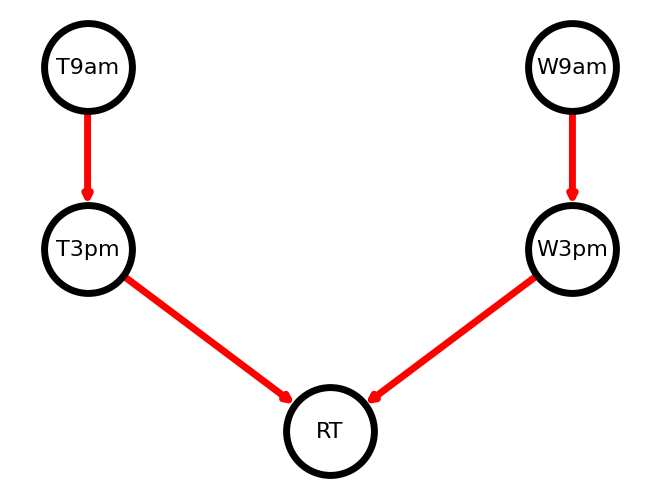

In [29]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 2), 3: (1, 0.5), 4: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca() 
ax.margins(0.10)
plt.axis("off")
plt.show()

In [30]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('****************')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.61013
2=>=16|0.38987
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.62636
1=24-36|0.32452
1=>26|0.04911
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39486
0=15-26|0.49902
0=>26|0.10613
****************
Node: 4|RT|No,Yes
Values:
4=No|0.77580
4=Yes|0.22420
****************


**Evidence 1: Time: 9 AM, Temperature: 30**

In [31]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('ev1', 'T9am', '>26', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.61013
2=>=16|0.38987
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.04411
1=24-36|0.66328
1=>26|0.29261
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.00000
0=15-26|0.00000
0=>26|1.00000
****************
Node: 4|RT|No,Yes
Values:
4=No|0.84061
4=Yes|0.15939
****************


**Evidence 2: Time: 9 AM, Temperature: 10**

In [33]:
evidence('ev2', 'T9am', '15-26', 1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.61013
2=>=16|0.38987
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.48281
1=24-36|0.48976
1=>26|0.02743
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.00000
0=15-26|1.00000
0=>26|0.00000
****************
Node: 4|RT|No,Yes
Values:
4=No|0.79227
4=Yes|0.20773
****************


**Evidence 3: Time: 3 PM, Temperature: 26**

In [35]:
evidence('ev3', 'T3pm', '>26', 1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.61013
2=>=16|0.38987
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.00000
1=24-36|0.00000
1=>26|1.00000
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.08903
0=15-26|0.27870
0=>26|0.63228
****************
Node: 4|RT|No,Yes
Values:
4=No|0.84138
4=Yes|0.15862
****************


**Evidence 4: Time: 3 PM, Temperature: 11**

In [37]:
evidence('ev4', 'T3pm', '<24', 1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.61013
2=>=16|0.38987
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|1.00000
1=24-36|0.00000
1=>26|0.00000
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.60787
0=15-26|0.38465
0=>26|0.00747
****************
Node: 4|RT|No,Yes
Values:
4=No|0.73356
4=Yes|0.26644
****************


**Evidence 5: Time: 9 AM, Wind speed: 11**

In [39]:
evidence('ev5', 'W9am', '<16', 1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.43071
3=>=15|0.56929
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|1.00000
2=>=16|0.00000
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.62636
1=24-36|0.32452
1=>26|0.04911
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39486
0=15-26|0.49902
0=>26|0.10613
****************
Node: 4|RT|No,Yes
Values:
4=No|0.78089
4=Yes|0.21911
****************


**Evidence 6: Time: 3 PM, Wind speed: 19**

In [44]:
evidence('ev6', 'W3pm', '>=15', 1.0)
print_probs()


Node: 3|W3pm|<15,>=15
Values:
3=<15|0.00000
3=>=15|1.00000
****************
Node: 2|W9am|<16,>=16
Values:
2=<16|0.51030
2=>=16|0.48970
****************
Node: 1|T3pm|<24,24-36,>26
Values:
1=<24|0.62636
1=24-36|0.32452
1=>26|0.04911
****************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39486
0=15-26|0.49902
0=>26|0.10613
****************
Node: 4|RT|No,Yes
Values:
4=No|0.76118
4=Yes|0.23882
****************
